<a href="https://colab.research.google.com/github/pringleshu/2025-1_CV/blob/main/%EC%8B%A4%ED%97%98A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 실험 A: CrossEntropy Loss 대 MSE Loss (Softmax 사용) - Fashion-MNIST

import torch
import torch.nn as nn  # 신경망 모듈
import torch.optim as optim  # 최적화 알고리즘
import torch.nn.functional as F  # 자주 사용되는 함수들 (예: softmax, one_hot)
from torchvision import datasets, transforms  # Torchvision 데이터셋 및 변환 도구
from torch.utils.data import DataLoader # 데이터 로딩 유틸리티
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INPUT_SIZE_FASHION_MNIST = 28 * 28 # Fashion-MNIST 이미지 크기
NUM_CLASSES = 10                 # 분류할 클래스 개수
DEFAULT_LEARNING_RATE = 0.001    # 학습률
DEFAULT_EPOCHS = 30              # 에포크 수


SEED = 42 #재현성, 삶과 우주, 그리고 모든 것에 대한 답은 42
torch.manual_seed(SEED) # PyTorch 시드
np.random.seed(SEED)    # NumPy 시드
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
class MLP(nn.Module): #기본 모델 생성함수, 예제대로 사용
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x) # Raw logits
        return x

In [4]:
def get_fashion_mnist_dataloaders(batch_size=64): #데이터셋 로드
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform) #train
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform) #test

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    #60000, 10000개 데이터
    return train_loader, test_loader, INPUT_SIZE_FASHION_MNIST, NUM_CLASSES

def one_hot_encode(labels, num_classes): #label을 원핫인코딩
    return F.one_hot(labels, num_classes=num_classes).float()


In [5]:
def evaluate_model(model, test_loader, loss_fn_name, num_classes): #모델을 평가하는 함수
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    # 손실 함수 명시적 생성
    if loss_fn_name == "CrossEntropy":
        loss_fn = nn.CrossEntropyLoss()
    elif loss_fn_name == "MSE":
        loss_fn = nn.MSELoss()
    else:
        raise ValueError(f"Unsupported loss function: {loss_fn_name}")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs_from_model = model(inputs)

            if loss_fn_name == "CrossEntropy":
                loss = loss_fn(outputs_from_model, labels)
                _, predicted = torch.max(outputs_from_model.data, 1)
            elif loss_fn_name == "MSE":
                probabilities = torch.softmax(outputs_from_model, dim=1)
                one_hot_labels = one_hot_encode(labels, num_classes).to(DEVICE)
                loss = loss_fn(probabilities, one_hot_labels)
                _, predicted = torch.max(probabilities.data, 1) # MSE는 확률로 예측

            running_loss += loss.item() * inputs.size(0)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    avg_loss = running_loss / len(test_loader.dataset) #avg loss
    accuracy = correct_test / total_test #accuracy
    return avg_loss, accuracy

In [6]:
def train_model(model, train_loader, optimizer, loss_fn_name, num_classes, epochs, dataset_name):
    #데이터 장치 설정
    model.to(DEVICE)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # 초기/최종 그래디언트 저장 딕셔너리
    gradient_collection = {
        'initial_fc1': None, 'initial_fc3': None,
        'final_fc1': None, 'final_fc3': None
    }

    # 손실 함수 선택 (CrossEntropy 또는 MSE)
    if loss_fn_name == "CrossEntropy":
        loss_fn = nn.CrossEntropyLoss()
    elif loss_fn_name == "MSE":
        loss_fn = nn.MSELoss()
    else:
        raise ValueError(f"Unsupported loss function: {loss_fn_name}")

    print(f"\n{loss_fn_name} 손실 함수로 {epochs} 에폭 학습 시작...")

    # 에폭 반복
    for epoch in range(epochs):
        model.train()  # 학습 모드 전환
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        start_time_epoch = time.time()

        # 배치 반복
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()  # 기울기 초기화

            outputs_from_model = model(inputs)  # 모델 순전파

            # 손실 계산 (MSE는 softmax + 원-핫 레이블)
            if loss_fn_name == "CrossEntropy":
                loss = loss_fn(outputs_from_model, labels)
            elif loss_fn_name == "MSE":
                probabilities = torch.softmax(outputs_from_model, dim=1)  # 확률 변환
                one_hot_labels = one_hot_encode(labels, num_classes).to(DEVICE)  # 원-핫 인코딩
                loss = loss_fn(probabilities, one_hot_labels)

            loss.backward()  # 역전파 수행

            # 첫/마지막 배치에서 그래디언트 저장
            if epoch == 0 and batch_idx == 0:
                if model.fc1.weight.grad is not None:
                    gradient_collection['initial_fc1'] = model.fc1.weight.grad.clone().detach().cpu().numpy().flatten()
                if model.fc3.weight.grad is not None:
                    gradient_collection['initial_fc3'] = model.fc3.weight.grad.clone().detach().cpu().numpy().flatten()
            if epoch == epochs - 1 and batch_idx == len(train_loader) - 1:
                if model.fc1.weight.grad is not None:
                    gradient_collection['final_fc1'] = model.fc1.weight.grad.clone().detach().cpu().numpy().flatten()
                if model.fc3.weight.grad is not None:
                    gradient_collection['final_fc3'] = model.fc3.weight.grad.clone().detach().cpu().numpy().flatten()

            optimizer.step()  # 파라미터 업데이트
            running_loss += loss.item() * inputs.size(0)  # 손실 누적

            # 예측값 생성
            if loss_fn_name == "CrossEntropy":
                _, predicted = torch.max(outputs_from_model.data, 1)
            elif loss_fn_name == "MSE":
                probabilities_for_acc = torch.softmax(outputs_from_model.data, dim=1) #softmax
                _, predicted = torch.max(probabilities_for_acc, 1)

            total_train += labels.size(0)            # 전체 개수 누적
            correct_train += (predicted == labels).sum().item()  # 정답 개수 누적

        # 에폭별 손실·정확도 계산
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # 검증 수행
        val_loss_epoch, val_acc_epoch = evaluate_model(model, test_loader, loss_fn_name, num_classes)
        val_losses.append(val_loss_epoch)
        val_accuracies.append(val_acc_epoch)

        # 에폭 진행 상황 출력
        epoch_duration = time.time() - start_time_epoch
        print(f"에폭 [{epoch+1}/{epochs}] - "
              f"학습 손실: {epoch_loss:.4f}, 학습 정확도: {epoch_acc:.4f} - "
              f"검증 손실: {val_loss_epoch:.4f}, 검증 정확도: {val_acc_epoch:.4f} - "
              f"소요시간: {epoch_duration:.2f}초")

    # 학습 이력 및 그래디언트 반환
    history = {
        'train_loss': train_losses, 'train_acc': train_accuracies,
        'val_loss': val_losses, 'val_acc': val_accuracies,
        'gradients': gradient_collection
    }
    return history


In [7]:
#학습 과정의 손실, 정확도 및 개별 그래디언트 분포를 시각화하는 함수
def plot_metrics(history, loss_fn_name, dataset_name):
    epochs_range = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.title(f'{dataset_name} - {loss_fn_name}: Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
    plt.title(f'{dataset_name} - {loss_fn_name}: Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.suptitle(f"Performance Metrics for {loss_fn_name} on {dataset_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [8]:
def plot_gradient_distributions(gradients, loss_fn_name, dataset_name):
    if all(grad_list is None or len(grad_list) == 0 for grad_list in gradients.values()):# 그래디언트 확인
        print(f"No gradients collected for {loss_fn_name} on {dataset_name}. Skipping gradient plot.")
        return

    plt.figure(figsize=(14, 10))
    plot_idx = 1

    for stage_key, stage_name_base in [ #초기, 최종단계
        ('initial', "Initial (Epoch 1, Batch 1)"),
        ('final', "Final (Last Epoch, Last Batch)")
    ]:
        for layer_key, layer_name_suffix in [# 레이어 순회 (fc1, fc3)
            ('fc1', "FC1 Weights"),
            ('fc3', "FC3 (Output Layer) Weights")
        ]:
            grad_data = gradients.get(f"{stage_key}_{layer_key}")
            if grad_data is not None and len(grad_data) > 0: # 유효한 데이터가 있을 때 히스토그램 그리기
                plt.subplot(2, 2, plot_idx) # 서브플롯 위치 지정
                plt.hist(grad_data, bins=50, alpha=0.7, density=True) # 분포 히스토그램
                mean_grad = np.mean(grad_data)# 평균 계산
                std_grad = np.std(grad_data) # 표준편차 계산
                plt.title(
                    f"{stage_name_base} {layer_name_suffix}\n"
                    f"Mean: {mean_grad:.2e}, Std: {std_grad:.2e}"
                )  # 타이틀에 통계 표시
                plt.xlabel("Gradient Value") # x축 레이블
                plt.ylabel("Density")# y축 레이블
                plt.grid(True) # 그리드 표시
                plot_idx += 1
            elif grad_data is None and plot_idx <= 4: #에러처리
                print(f"No gradient data for {stage_name_base} {layer_name_suffix}.")

    plt.suptitle(f"Gradient Distributions for {loss_fn_name} on {dataset_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


시작


100%|██████████| 26.4M/26.4M [00:01<00:00, 15.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 278kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.21MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.4MB/s]


손실 함수: CrossEntropy 테스트

CrossEntropy 손실 함수로 30 에폭 학습 시작...
에폭 [1/30] - 학습 손실: 0.4955, 학습 정확도: 0.8193 - 검증 손실: 0.4522, 검증 정확도: 0.8361 - 소요시간: 21.04초
에폭 [2/30] - 학습 손실: 0.3712, 학습 정확도: 0.8633 - 검증 손실: 0.3933, 검증 정확도: 0.8571 - 소요시간: 21.72초
에폭 [3/30] - 학습 손실: 0.3303, 학습 정확도: 0.8779 - 검증 손실: 0.3682, 검증 정확도: 0.8685 - 소요시간: 21.76초
에폭 [4/30] - 학습 손실: 0.3076, 학습 정확도: 0.8862 - 검증 손실: 0.3509, 검증 정확도: 0.8733 - 소요시간: 21.98초
에폭 [5/30] - 학습 손실: 0.2854, 학습 정확도: 0.8942 - 검증 손실: 0.3574, 검증 정확도: 0.8729 - 소요시간: 21.25초
에폭 [6/30] - 학습 손실: 0.2705, 학습 정확도: 0.8983 - 검증 손실: 0.3405, 검증 정확도: 0.8786 - 소요시간: 22.73초
에폭 [7/30] - 학습 손실: 0.2562, 학습 정확도: 0.9033 - 검증 손실: 0.3579, 검증 정확도: 0.8760 - 소요시간: 22.43초
에폭 [8/30] - 학습 손실: 0.2444, 학습 정확도: 0.9080 - 검증 손실: 0.3517, 검증 정확도: 0.8788 - 소요시간: 21.38초
에폭 [9/30] - 학습 손실: 0.2334, 학습 정확도: 0.9114 - 검증 손실: 0.3333, 검증 정확도: 0.8845 - 소요시간: 21.48초
에폭 [10/30] - 학습 손실: 0.2215, 학습 정확도: 0.9159 - 검증 손실: 0.3292, 검증 정확도: 0.8854 - 소요시간: 22.16초
에폭 [11/30] - 학습 손실: 0.2109, 학습 정확도: 0.9204 - 검증 손

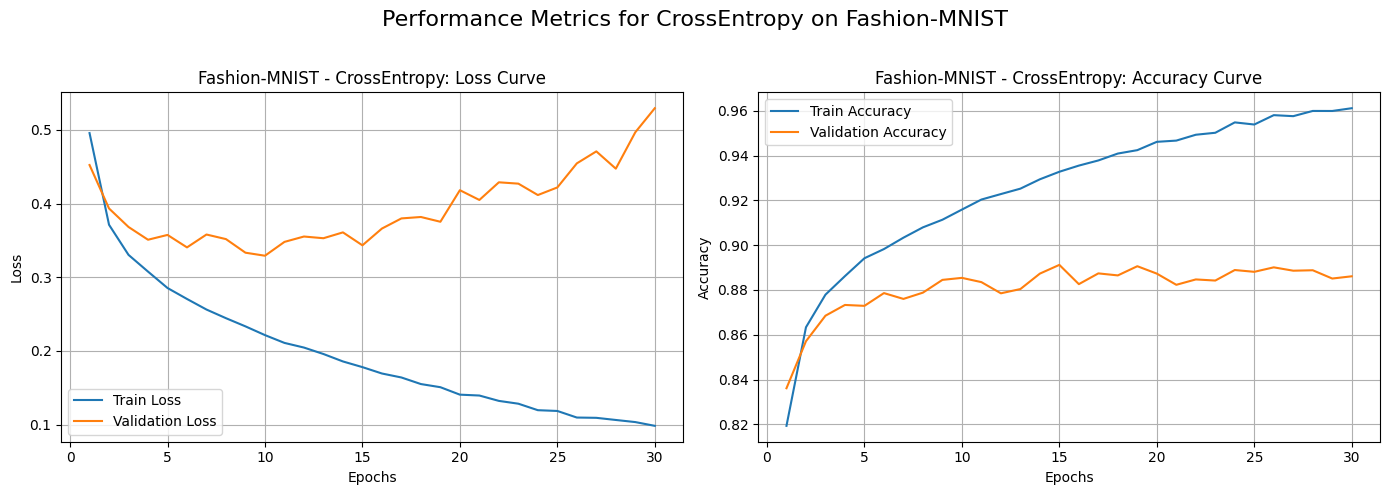

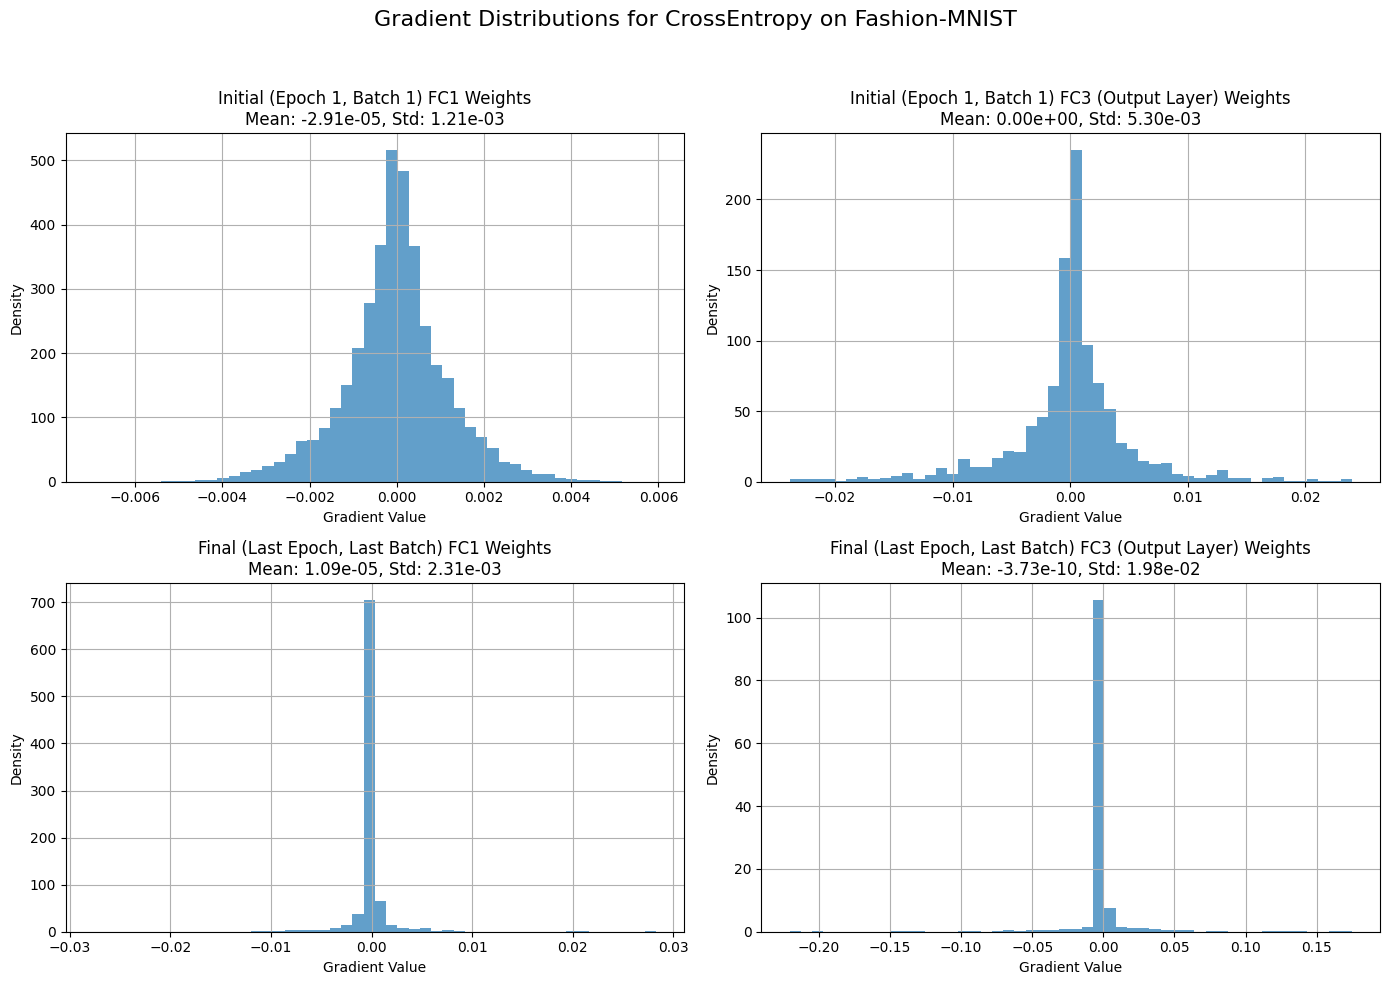


Fashion-MNIST - CrossEntropy 분석 포인트:
  - 최종 검증 정확도: 88.61%
  - 최소 검증 손실: 0.3292
손실 함수: MSE 테스트

MSE 손실 함수로 30 에폭 학습 시작...
에폭 [1/30] - 학습 손실: 0.0257, 학습 정확도: 0.8171 - 검증 손실: 0.0217, 검증 정확도: 0.8489 - 소요시간: 21.10초
에폭 [2/30] - 학습 손실: 0.0199, 학습 정확도: 0.8603 - 검증 손실: 0.0218, 검증 정확도: 0.8442 - 소요시간: 21.74초
에폭 [3/30] - 학습 손실: 0.0181, 학습 정확도: 0.8752 - 검증 손실: 0.0204, 검증 정확도: 0.8590 - 소요시간: 22.05초
에폭 [4/30] - 학습 손실: 0.0171, 학습 정확도: 0.8825 - 검증 손실: 0.0188, 검증 정확도: 0.8695 - 소요시간: 22.00초
에폭 [5/30] - 학습 손실: 0.0162, 학습 정확도: 0.8884 - 검증 손실: 0.0189, 검증 정확도: 0.8693 - 소요시간: 21.28초
에폭 [6/30] - 학습 손실: 0.0152, 학습 정확도: 0.8953 - 검증 손실: 0.0183, 검증 정확도: 0.8729 - 소요시간: 22.11초
에폭 [7/30] - 학습 손실: 0.0148, 학습 정확도: 0.8986 - 검증 손실: 0.0181, 검증 정확도: 0.8771 - 소요시간: 21.87초
에폭 [8/30] - 학습 손실: 0.0141, 학습 정확도: 0.9048 - 검증 손실: 0.0189, 검증 정확도: 0.8734 - 소요시간: 21.50초
에폭 [9/30] - 학습 손실: 0.0137, 학습 정확도: 0.9074 - 검증 손실: 0.0183, 검증 정확도: 0.8726 - 소요시간: 21.66초
에폭 [10/30] - 학습 손실: 0.0132, 학습 정확도: 0.9115 - 검증 손실: 0.0171, 검증 정확도: 0.8840 -

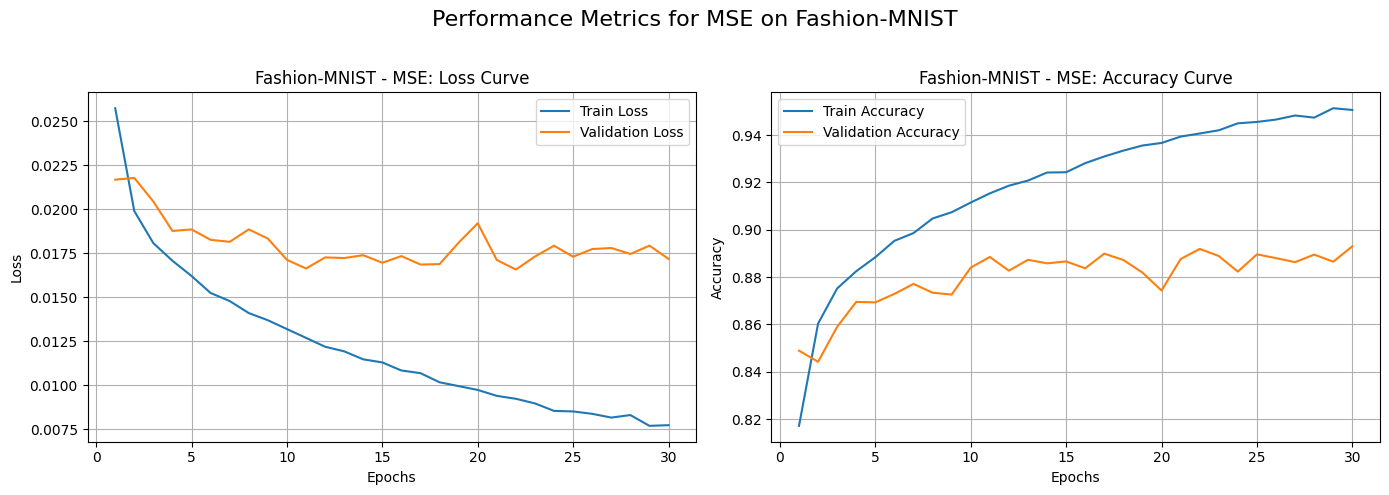

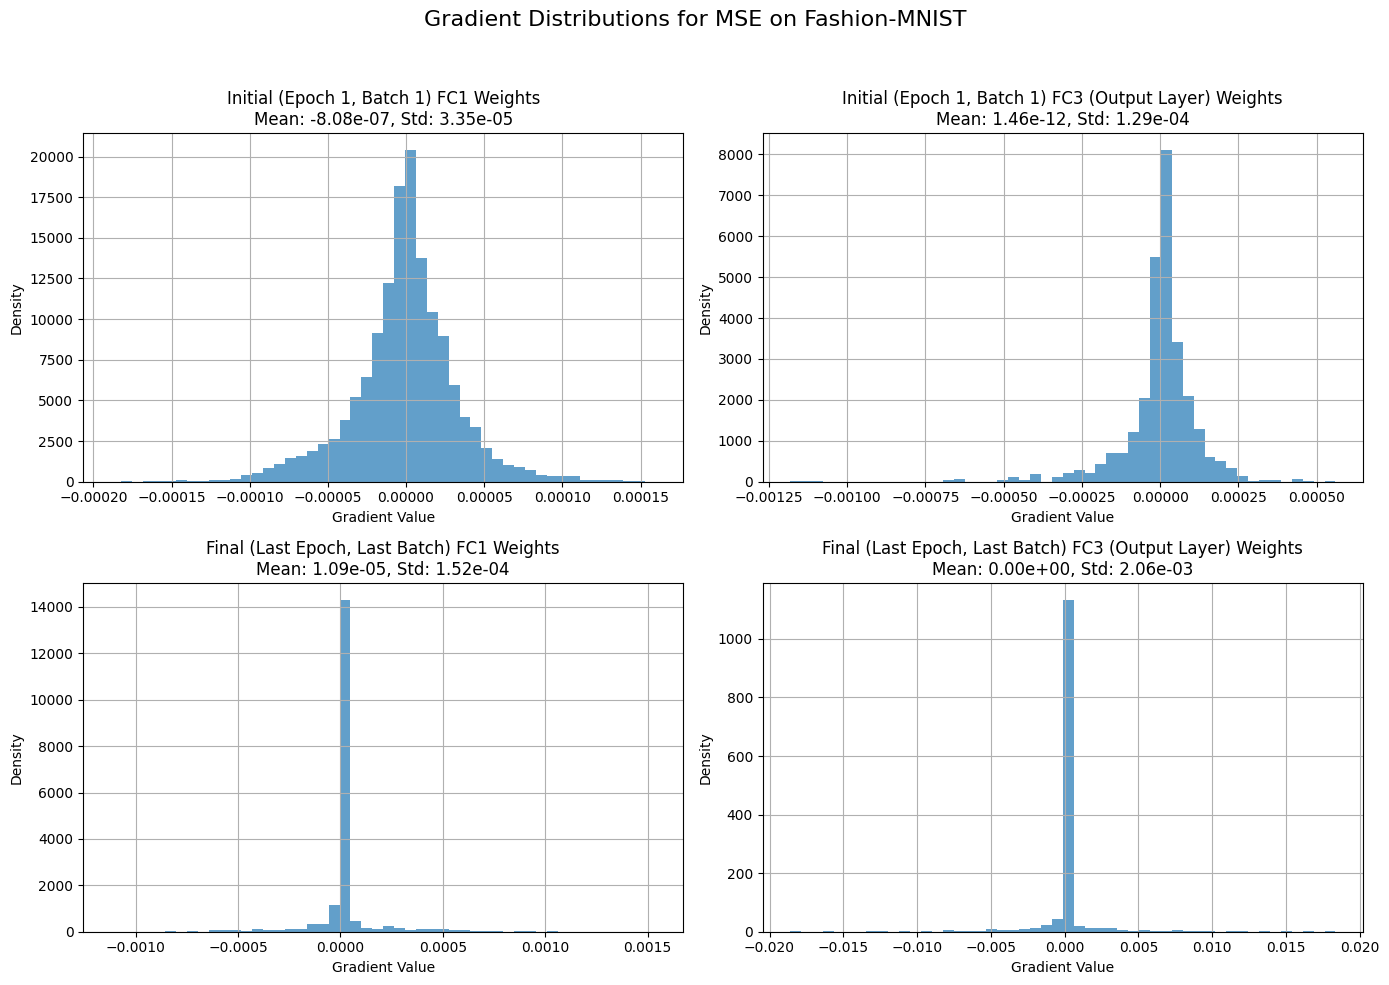


Fashion-MNIST - MSE 분석 포인트:
  - 최종 검증 정확도: 89.30%
  - 최소 검증 손실: 0.0166


In [9]:
dataset_name_to_run = "Fashion-MNIST"

loss_functions_to_compare = ["CrossEntropy", "MSE"] #반복문 사용을 위한 list

all_experiment_histories = {}
experiment_summary_table_data = []

# criterion_ce, criterion_mse 변수 제거 (train_model 내부에서 생성)

print("시작")


train_loader, test_loader, input_size, num_classes = get_fashion_mnist_dataloaders()

for loss_fn in loss_functions_to_compare:

    print(f"손실 함수: {loss_fn} 테스트")


    model = MLP(input_size=input_size, num_classes=num_classes)

    # 옵티마이저 명시적 생성
    optimizer = optim.Adam(model.parameters(), lr=DEFAULT_LEARNING_RATE)

    start_time_total_train = time.time()
    # train_model 호출 시 criterion_ce, criterion_mse 제거
    history = train_model(
        model, train_loader, optimizer,
        loss_fn, # loss_fn 문자열로 전달
        num_classes, DEFAULT_EPOCHS, dataset_name_to_run
    )
    total_train_time = time.time() - start_time_total_train
    print(f"{dataset_name_to_run},{loss_fn} 사용 시 총 학습 시간: {total_train_time:.2f}초")

    all_experiment_histories[(dataset_name_to_run, loss_fn)] = history

    plot_metrics(history, loss_fn, dataset_name_to_run)
    plot_gradient_distributions(history['gradients'], loss_fn, dataset_name_to_run)

    final_val_loss = history['val_loss'][-1]
    final_val_acc = history['val_acc'][-1]
    min_val_loss = min(history['val_loss'])

    experiment_summary_table_data.append({
        "Dataset": dataset_name_to_run,
        "Loss Function": loss_fn,
        "Final Validation Accuracy (%)": final_val_acc * 100,
        "Min Validation Loss": min_val_loss,
        "Final Validation Loss": final_val_loss,
        "Epochs Trained": DEFAULT_EPOCHS,
        "Training Time (s)": total_train_time
    })

    print(f"\n{dataset_name_to_run} - {loss_fn} 분석 포인트:")
    print(f"  - 최종 검증 정확도: {final_val_acc*100:.2f}%")
    print(f"  - 최소 검증 손실: {min_val_loss:.4f}")



In [10]:
print(f"{'데이터셋':<15} | {'손실 함수':<15} | {'최종 검증 정확도 (%)':<22} | {'최소 검증 손실':<15} | {'최종 검증 손실':<15} | {'학습 에폭':<8} | {'학습 시간 (초)':<12}")
print("-" * 125)
print("==============================================================")


데이터셋            | 손실 함수           | 최종 검증 정확도 (%)          | 최소 검증 손실        | 최종 검증 손실        | 학습 에폭    | 학습 시간 (초)   
-----------------------------------------------------------------------------------------------------------------------------
